In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('../../')
from Dataset_Creation import sys_dataset
import Dataset_load

In [3]:
dataset_standard  = Dataset_load.create_asimov()
dataset_asimov  = Dataset_load.create_asimov()

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'
factor = +0.
sigma = 0.1

In [5]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

factor_rnds = infos[:N_max,0]
stat_sums = infos[:N_max,1]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilt = pars[:N_max,6:8]



1000


In [6]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = factor, 
                        tilt = 0,
                        bias = 0,
                        resolution = 0,
                        rnd = False,
                        e_reco_creation=10)
dataset_asimov = sys_d_cor.create_dataset()
dataset_asimov_N = sys_d_cor.create_dataset_N(10)


zero = 1e-24
    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/sigma**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


In [7]:
%%time
fitting = False

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov)
    dataset_asimov.models.covariance = fit_cor.covariance(dataset_asimov).matrix
    dataset_asimov.models.covariance.plot_correlation()
    print(fit_cor.minuit)

    fit_cor_N = Fit(store_trace=True)
    fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N = fit_cor_N.run(dataset_asimov_N)
    dataset_asimov_N.models.covariance = fit_cor_N.covariance(dataset_asimov_N).matrix
    dataset_asimov_N.models.covariance.plot_correlation()
    print(fit_cor_N.minuit)
    
    
    print("saving")
    path = f'data/2_model_{factor}.yml'
    dataset_asimov.models.write(path,overwrite=True)
    path = f'data/2_model_nui_{factor}.yml'
    dataset_asimov_N.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/2_model_{factor}.yml'
    dataset_asimov = Dataset_load.load_dataset_N(dataset_asimov, path)        
    path = f'data/2_model_nui_{factor}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)         


read
CPU times: user 156 ms, sys: 154 ms, total: 310 ms
Wall time: 89.2 ms


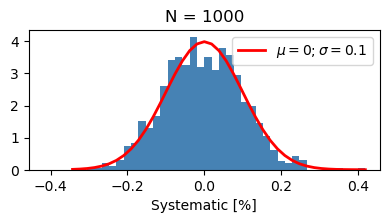

In [8]:
fig, axs = plt.subplots(1,1, figsize = (4,7/3))

count, bins, ignored = plt.hist(factor_rnds, 40, density=True, color = 'steelblue')
sigma = 0.1
mu = 0
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

plt.xlabel("Systematic [%]")
plt.title(f"N = {N}")
plt.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_rnd_sys_{factor}_{N}." + picformat)   
    


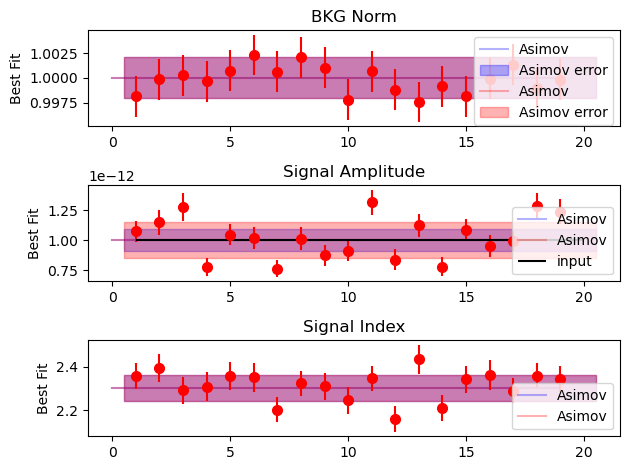

In [9]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")

N_plot = 20
labels = [ '-10%', '0%', '10%']

colors = ['blue', 'red']
for i, d in enumerate([dataset_asimov, dataset_asimov_N]):
    
    best = d.models.parameters['norm'].value
    er = d.models.parameters['norm'].error
    axs[0].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")
    axs[0].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3,
                        label = "Asimov error")
    
    best = d.models.parameters['amplitude'].value
    er = d.models.parameters['amplitude'].error
    axs[1].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3)
    axs[1].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")

    best = d.models.parameters['index'].value
    er = d.models.parameters['index'].error
    axs[2].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3)
    axs[2].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")

for i, a in enumerate(norms[1:N_plot]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[0].hlines( norms[0][0], 1, N, label = "input", color = 'black')


for i, a in enumerate(amplitudes[1:N_plot]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( 1e-12, 1, N_plot, label = "input", color ='black')


for i, a in enumerate(indices[1:N_plot]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[2].hlines( indices[0][0], 1, N, label = "input", color ='black')



plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 

plt.tight_layout()    
#if savefig:
#    fig.savefig(f"plots/7b_best_fit_{factor}_{N}.pdf")   


#### get asymm errors

In [10]:
import json
with open("/home/katrin/Documents/nuisance_summary/config.json") as json_data_file:
    config = json.load(json_data_file)

import sys
sys.path.append(config['local']['path']+'/nuisance_summary/Eff_area')
import upper_limit_18_02

In [11]:
def get_er_neg_pos(parameter, N):
    filename = '5_scan_'+parameter
    if N:
        filename += '_N'
    filename += '.yaml'
    with open('data/'+filename) as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
        
    ll_N_a = stat_profile_N_a.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)    
    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    return er_neg, er_pos

In [12]:
valuies_asimov_N = []
valuies_asimov = []

par_names = ['norm', 'amplitude', 'index']

for par in par_names:

    er_neg, er_pos = get_er_neg_pos(par, True)
    valuies_asimov_N.append([dataset_asimov_N.models.parameters[par].value, er_neg, er_pos])
    
    er_neg, er_pos = get_er_neg_pos(par, False)
    valuies_asimov.append([dataset_asimov.models.parameters[par].value, er_neg, er_pos])

print(valuies_asimov_N)
print(valuies_asimov)



[[1.0000032236016694, 0.0020832086021266294, 0.0020528973658524574], [1.0023773984781716e-12, 1.2640078905039213e-13, 1.4811981007917483e-13], [2.3014613026160693, 0.06280804428894537, 0.06396199785855794]]
[[1.0000033054393866, 0.002067268040327086, 0.002070006143692016], [1.0022820339853156e-12, 9.078162942078264e-14, 9.366740307124453e-14], [2.3014342501653635, 0.06261440832018339, 0.06420488125879809]]


In [13]:

valuies = [norms, amplitudes, indices]

'''valuies_asimov = [[dataset_asimov.models.parameters['norm'].value, 
                   dataset_asimov.models.parameters['norm'].error],
                  [dataset_asimov.models.parameters['amplitude'].value, 
                   dataset_asimov.models.parameters['amplitude'].error],
                  [dataset_asimov.models.parameters['index'].value, 
                   dataset_asimov.models.parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models.parameters['norm'].value, 
                   dataset_asimov_N.models.parameters['norm'].error],
                  [dataset_asimov_N.models.parameters['amplitude'].value, 
                   dataset_asimov_N.models.parameters['amplitude'].error],
                  [dataset_asimov_N.models.parameters['index'].value, 
                   dataset_asimov_N.models.parameters['index'].error],]'''
is_within_norm = []
is_within_amplitude = []
is_within_index = []
is_within_norm_N = []
is_within_amplitude_N = []
is_within_index_N = []

i = 0
for n in norms:
    larger = np.all(n[0] >= (valuies_asimov[0][0] - valuies_asimov[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov[0][0] + valuies_asimov[0][2]))
    is_within_norm.append(larger and smaller)
    
    larger = np.all(n[0] >= (valuies_asimov_N[0][0] - valuies_asimov_N[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov_N[0][0] + valuies_asimov_N[0][2]))
    is_within_norm_N.append(larger and smaller)
    
for a in amplitudes:
    larger = np.all(a[0] >= (valuies_asimov[1][0] - valuies_asimov[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov[1][0] + valuies_asimov[1][2]))
    is_within_amplitude.append(larger and smaller)
    
    larger = np.all(a[0] >= (valuies_asimov_N[1][0] - valuies_asimov_N[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov_N[1][0] + valuies_asimov_N[1][2]))
    is_within_amplitude_N.append(larger and smaller)
    
for i in indices:
    larger = np.all(i[0] >= (valuies_asimov[2][0] - valuies_asimov[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov[2][0] + valuies_asimov[2][2]))
    is_within_index.append(larger and smaller)
    
    larger = np.all(i[0] >= (valuies_asimov_N[2][0] - valuies_asimov_N[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov_N[2][0] + valuies_asimov_N[2][2]))
    is_within_index_N.append(larger and smaller)
    
within_norm = [np.count_nonzero(is_within_norm)/N,
              np.count_nonzero(is_within_norm_N)/N]

within_amplitude = [np.count_nonzero(is_within_amplitude)/N,
              np.count_nonzero(is_within_amplitude_N)/N]

within_index = [np.count_nonzero(is_within_index)/N,
              np.count_nonzero(is_within_index_N )/N]

withins = [within_norm, 
          within_amplitude,
          within_index]

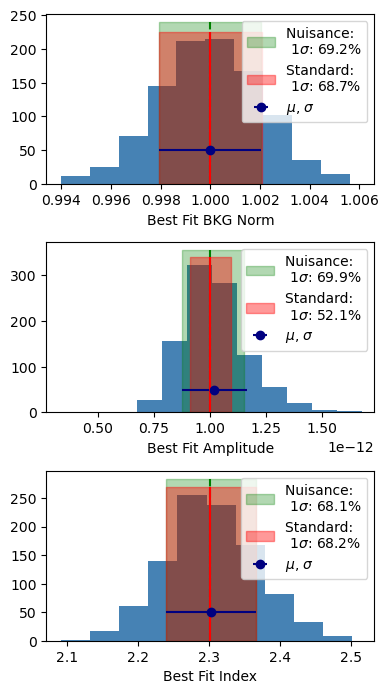

In [14]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]

axs[2].errorbar(x = np.mean(indices[:,0]) ,y = 50, xerr = np.std(indices[:,0]), fmt='o', 
                color = 'navy', label = "$\mu$, $\sigma$")
axs[1].errorbar(x = np.mean(amplitudes[:,0]) ,y = 50, xerr = np.std(amplitudes[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
axs[0].errorbar(x = np.mean(norms[:,0]) ,y = 50, xerr = np.std(norms[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
    

for i, v in enumerate(valuies):
    axs[i].hist(v[1:,0], color ='steelblue')
    ylim = axs[i].get_ylim()
    delta_ylim = 15
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][2]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = f'Nuisance: \n 1$\sigma$: {withins[i][1]*100 :.3}%')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][2]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = f'Standard: \n 1$\sigma$: {withins[i][0]*100 :.3}%'  )
    
    axs[i].legend(loc = 'upper right')  
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    

plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7b_histo_{factor}_{N}."+ picformat)

In [15]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]


asimov, asimov_errors = dataset_asimov.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_asimov_N.models[0].spectral_model.evaluate_error(ebins)


In [16]:
withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]   
        lowerlim = (np.all(value <= asimov.value[ie] + asimov_errors_pos.value[ie]))
        upperlim = (np.all(value >= asimov.value[ie] - asimov_errors_neg.value[ie]))
        x = lowerlim & upperlim
        xs.append(x)
        
        lowerlim = (np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie]))
        upperlim = (np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie]))
        x = lowerlim & upperlim
        xs_N.append(x)
        
        
    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)


NameError: name 'asimov_errors_pos' is not defined

In [ ]:
mean = flux2e.mean(axis = 0)
std = flux2e.std(axis = 0)

In [ ]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1,figsize = (5,3) )
for i, f in enumerate(flux2e):
    axs.plot(ebins, f, color = 'grey', alpha = 10/N)
axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
            label = "Mean and Std")

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )
axs.legend()
axs.set_xlabel("Energy [TeV]")
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_rnd_spectra_{factor}_{N}." + picformat)

In [ ]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)
p = compute_precision(N)

In [ ]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 2]},
                         sharex = True, figsize = ((5,5)))
axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
            label = "Mean and Std")
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    


dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red")    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )
ax2.errorbar(ebins, withine,yerr = p, color = 'red', label = "Standard")
ax2.errorbar(ebins, withine_N, yerr = p,color = 'green', label = "Nuisance")
ax2.plot(ebins, [0.68] * len(ebins), ':', color = 'green', label = "68 %")

axs.set_xlabel('')
axs.legend()
ax2.legend(ncol = 2)
axs.set_title(f"N = {N}")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage')

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_spectra_{factor}_{N}." + picformat)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(indices[:,0], amplitudes[:,0], stat_sums, marker='o')
    
